In [1]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
from generax.trainer import Trainer
import matplotlib.pyplot as plt
import equinox as eqx
from jaxtyping import Array, PRNGKeyArray
import generax as gx
from generax.distributions.flow_models import TimeDependentNormalizingFlow, ContinuousNormalizingFlow

## Here we'll show how to train continuous normalizing flows using flow matching

In [2]:
class EmpiricalDistribution(gx.ProbabilityDistribution):
  data: Array
  def __init__(self, data):
    self.data = data
    x_shape = data.shape[1:]
    super().__init__(data_shape=x_shape)

  def sample_and_log_prob(self):
    assert 0, "Can't compute"
  def log_prob(self):
    assert 0, "Can't compute"

  def sample(self, key):
    return random.choice(key, self.data, shape=(1,))[0]

  def train_iterator(self, key, batch_size):
    total_choices = jnp.arange(self.data.shape[0])
    while True:
      key, _ = random.split(key, 2)
      idx = random.choice(key,
                          total_choices,
                          shape=(batch_size,),
                          replace=True)
      yield dict(x=self.data[idx])

In [3]:
from sklearn.datasets import make_swiss_roll
data, y = make_swiss_roll(n_samples=100000, noise=0.5)
data = data[:, [0, 2]]
data = data - data.mean(axis=0)
data = data/data.std(axis=0)
p1 = EmpiricalDistribution(data)

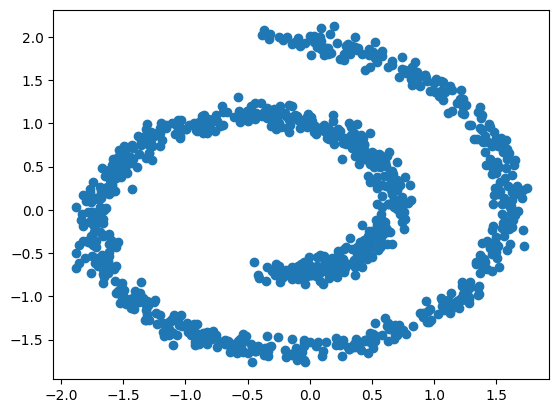

In [4]:
key = random.PRNGKey(0)
keys = random.split(key, 1000)
samples = eqx.filter_vmap(p1.sample)(keys)
plt.scatter(*samples.T)

A probability path is a time dependent probability distribution $p_t$ from $t=0$ to $t=1$.  We want $p_0 = N(0,I)$ and $p_1 = p_{\text{data}}$.  We can construct this path as the expectation of a conditional probability path:
$$
p_t(x_t) = \int p_1(x_1)p_t(x_t|x_1)dx_1
$$
One choice for the conditional distribution is $p_t(x_t|x_1) = N(x_t|tx_1,(1-t)^2I)$, which is a linear interpolation between $x_0=0$ and $x_1$ (conditional optimal transport).

In [5]:
x_shape = p1.data_shape
transform = gx.ConditionalOptionalTransport(input_shape=x_shape, key=key)
cond_ppath = TimeDependentNormalizingFlow(transform=transform,
                                             prior=gx.Gaussian(data_shape=x_shape))

In [6]:
p0 = gx.Gaussian(data_shape=x_shape)

In [7]:
def sample_xt(t, key):
  k1, k2 = random.split(key, 2)
  x1 = p1.sample(k1)
  x0 = p0.sample(k2)
  xt = cond_ppath.to_data_space(t, x0, x1)
  return xt

ts = jnp.linspace(0, 1, 6)
keys = random.split(key, 1000)
xt_samples = jax.vmap(jax.vmap(sample_xt, in_axes=(0, None)), in_axes=(None, 0))(ts, keys)

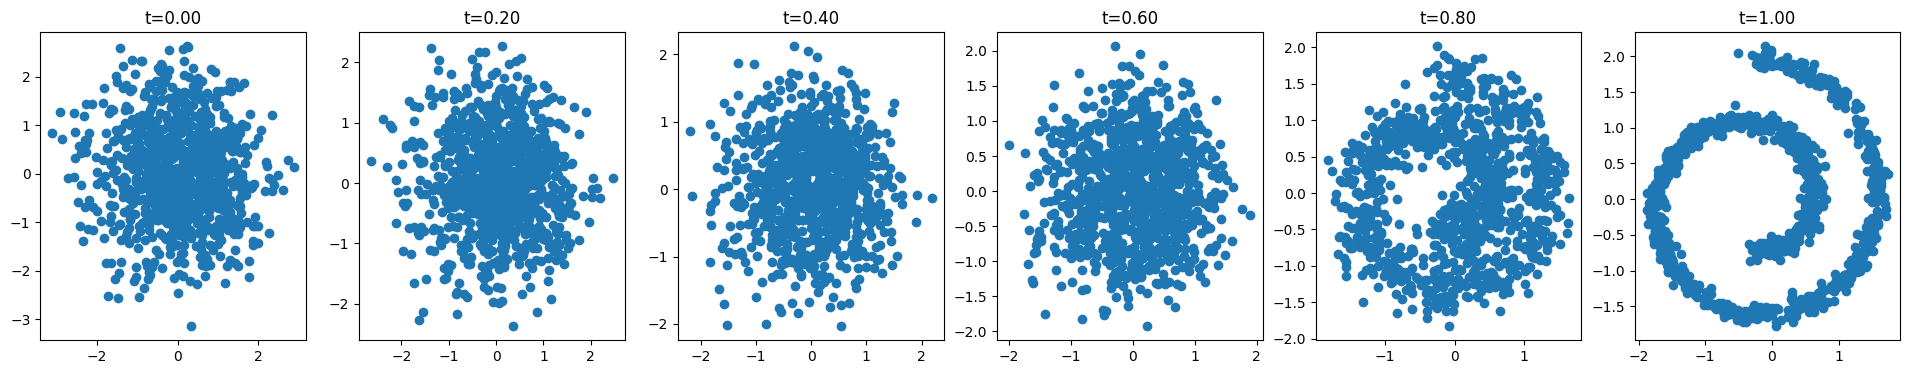

In [8]:
n_rows, n_cols = 1, ts.shape[0]
size = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))
for i in range(n_cols):
  axes[i].scatter(*xt_samples[:,i].T)
  axes[i].set_title(f"t={ts[i]:.2f}")

Without using any parameters, we constructed a path between a Gaussian and our data.  Next, we'll learn a continuous normalizing flow that will learn this probability path.

In [9]:
# Construct the neural network that learn the score
net = gx.TimeDependentResNet(input_shape=x_shape,
                          working_size=16,
                          hidden_size=32,
                          out_size=x_shape[-1],
                          n_blocks=5,
                          embedding_size=16,
                          out_features=32,
                          key=key)
flow = ContinuousNormalizingFlow(input_shape=x_shape,
                                  net=net,
                                  key=key,
                                  controller_atol=1e-5,
                                  controller_rtol=1e-5)


In [10]:
def loss(flow, data, key):

  def unbatched_loss(data, key):
    k1, k2 = random.split(key, 2)

    # Sample
    x1 = data['x']
    x0 = cond_ppath.prior.sample(k1)
    t = random.uniform(k2)

    # Compute f_t(x_0; x_1)
    def ft(t):
      return cond_ppath.to_data_space(t, x0, x1)
    xt, ut = jax.jvp(ft, (t,), (jnp.ones_like(t),))

    # Compute the parametric vector field
    vt = flow.net(t, xt)

    # Compute the loss
    return jnp.sum((ut - vt)**2)

  keys = random.split(key, data['x'].shape[0])
  objective = jax.vmap(unbatched_loss)(data, keys).mean()
  aux = dict(objective=objective)
  return objective, aux

In [11]:
# Create the optimizer
import optax
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0,
                                  peak_value=1.0,
                                  warmup_steps=1000,
                                  decay_steps=3e5,
                                  end_value=0.1,
                                  exponent=1.0)
chain = []
chain.append(optax.clip_by_global_norm(15.0))
chain.append(optax.adamw(1e-3))
chain.append(optax.scale_by_schedule(schedule))
optimizer = optax.chain(*chain)

# Create the trainer and optimize
trainer = Trainer(checkpoint_path='tmp/flow/flow_matching')
flow = trainer.train(model=flow,
                      objective=loss,
                      evaluate_model=lambda x: x,
                      optimizer=optimizer,
                      num_steps=30000,
                      double_batch=1000,
                      data_iterator=p1.train_iterator(key, batch_size=128),
                      checkpoint_every=5000,
                      test_every=-1,
                      retrain=True)

loss: 2.9090:  20%|██        | 6000/30000 [00:22<01:10, 340.63it/s]

Checkpointed model


loss: 2.8846:  37%|███▋      | 11000/30000 [00:38<01:01, 310.04it/s]

Checkpointed model


loss: 2.8767:  53%|█████▎    | 16000/30000 [00:51<00:35, 397.60it/s]

Checkpointed model


loss: 2.8872:  70%|███████   | 21000/30000 [01:01<00:18, 482.02it/s]

Checkpointed model


loss: 2.8765:  87%|████████▋ | 26000/30000 [01:11<00:07, 502.76it/s]

Checkpointed model


loss: 2.8664:   0%|          | 30/30000 [01:18<21:54:47,  2.63s/it] 

Checkpointed model


In [12]:
ts = jnp.linspace(0, 1, 6)

def ode_solve(x0):
  z, log_det = flow.transform.neural_ode(x0,
                              inverse=True,
                              log_likelihood=True,
                              save_at=ts)
  return z, log_det

n_samples = 10000
keys = random.split(key, n_samples)
x0, log_p0s = eqx.filter_vmap(flow.prior.sample_and_log_prob)(keys)
xts, log_dets = jax.vmap(ode_solve)(x0)
log_pxs = log_p0s[:,None] - log_dets

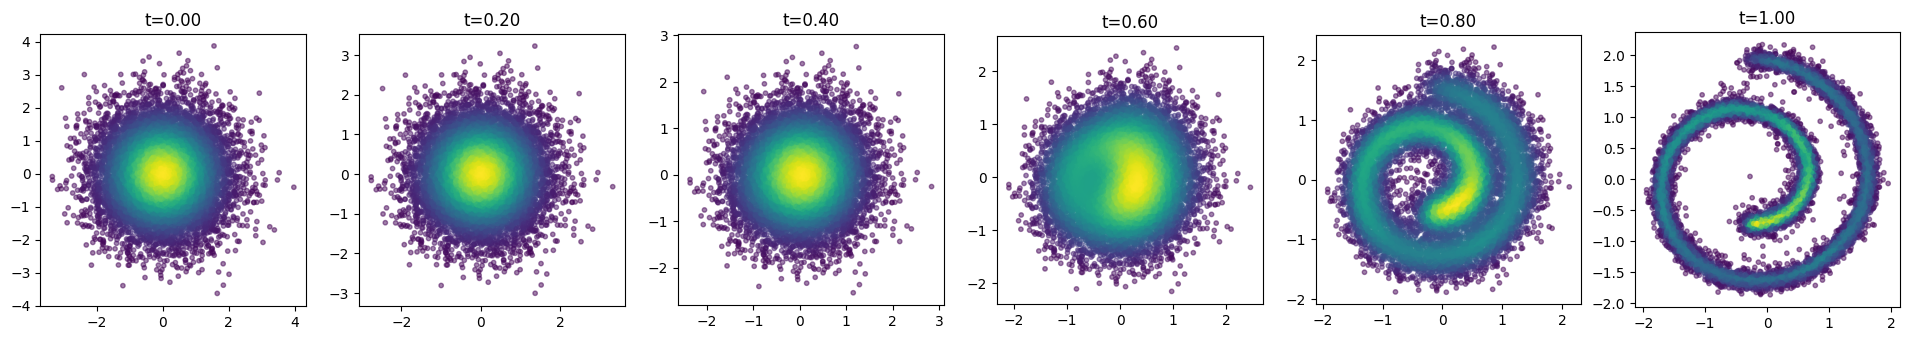

In [13]:
n_rows, n_cols = 1, ts.shape[0]
size = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))
for i in range(n_cols):
  axes[i].scatter(*xts[:,i].T, c=jnp.exp(log_pxs[:,i]), alpha=0.5, s=10)
  axes[i].set_title(f"t={ts[i]:.2f}")
  axes[i].set_aspect('equal', 'box')
